In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import json

import torchvision
import torch

from pathlib import Path
from PIL import Image
from pprint import pprint
from tqdm import tqdm

from torch import nn, optim
from torchvision.models import resnet50
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import WeightedRandomSampler

# custom imports
from fairface_classification import data, resnet_model, utils, metrics, train

# launch tensorboard writer
writer = SummaryWriter('../runs/fairface/')

utils.set_random_seed(42)

%matplotlib inline
%load_ext autoreload
%autoreload 2

### The following is the model architecture I am going to train on FairFace Dataset

Almost the whole model and its architecture - ResNet50 pretrained on ImageNet dataset. The last layer is modified and adapted to current FairFace dataset. There are just 3 classes that should predicted at the same time, so the last layer of the model will have three "heads".

In [2]:
show_pic = False

if show_pic:
    Image.open('../model_architecture.png')

In [3]:
train_label = pd.read_csv('../data/fairface_label_train.csv')
resnet = resnet50(weights='IMAGENET1K_V1')
train_label.head()

,file,age,gender,race,service_test
0,train/1.jpg,50-59,Male,East Asian,True
1,train/2.jpg,30-39,Female,Indian,False
2,train/3.jpg,3-9,Female,Black,False
3,train/4.jpg,20-29,Female,Indian,True
4,train/5.jpg,20-29,Female,Indian,True


In [4]:
resnet.load_state_dict(torch.load('../models/improved-net.pt'))

<All keys matched successfully>

### Initialize Dataset and Dataloader

In [5]:
race_dict = data.read_json('../data/encodings/race_encoding.json')
gender_dict = data.read_json('../data/encodings/gender_encoding.json')
age_dict = data.read_json('../data/encodings/age_encoding.json')

encoders = {'race' : race_dict, 'age' : age_dict, 'gender' : gender_dict}
pprint(encoders)

{'age': {'0-2': 0,
         '10-19': 2,
         '20-29': 3,
         '3-9': 1,
         '30-39': 4,
         '40-49': 5,
         '50-59': 6,
         '60-69': 7,
         'more than 70': 8},
 'gender': {'Female': 1, 'Male': 0},
 'race': {'Black': 4,
          'East Asian': 3,
          'Indian': 2,
          'Latino_Hispanic': 1,
          'Middle Eastern': 6,
          'Southeast Asian': 5,
          'White': 0}}


In [6]:
train_samples = json.load(open('../train_test_val.json'))['train']
label_train_test = pd.read_csv('../data/fairface_label_train.csv')

class_weights = utils.calc_tasks_weight({'age' : age_dict, 'gender' : gender_dict, 'race' : race_dict})
train_labels = utils.calc_category_weights(train_samples, label_train_test, {'age_dict' : age_dict, 'race_dict' : race_dict, 'gender_dict' : gender_dict})

       age: 1.50
      race: 1.17
    gender: 0.33


In [7]:
def group_class_weight(labels):
    """
    It is another way of calculation of image weight for oversampling technique.

    Args:
        labels: pd.DataFrame - dataframe with filenames and its labels.
    Returns:
        labels: pd.DataFrame - dataframe with calculated weights for every file and its labels.
    """

    labels['group'] = labels.apply(lambda x: f'{x["age"]}{x["gender"]}{x["race"]}', axis=1)
    group_vc = labels['group'].value_counts()
    group_counts = group_vc.to_frame().reset_index()
    labels = labels.merge(group_counts, on='group', how='left') 
    labels['group_weight'] = 1 / labels['count']
    return labels

train_labels = group_class_weight(train_labels)
train_labels.head()

,file,age,gender,race,age_weight,gender_weight,race_weight,total_weight,group,count,group_weight
0,train/1.jpg,6,0,3,0.000202,0.000027,0.000102,0.000330,603,272,0.003676
1,train/2.jpg,4,1,2,0.000065,0.000031,0.000102,0.000197,412,931,0.001074
2,train/4.jpg,3,1,2,0.000049,0.000031,0.000102,0.000181,312,1347,0.000742
3,train/5.jpg,3,1,2,0.000049,0.000031,0.000102,0.000181,312,1347,0.000742
4,train/7.jpg,5,0,6,0.000116,0.000027,0.000136,0.000279,506,961,0.001041


In [8]:
train_labels.drop(['age_weight', 'gender_weight', 'race_weight', 'total_weight'], axis=1)

,file,age,gender,race,group,count,group_weight
0,train/1.jpg,6,0,3,603,272,0.003676
1,train/2.jpg,4,1,2,412,931,0.001074
2,train/4.jpg,3,1,2,312,1347,0.000742
3,train/5.jpg,3,1,2,312,1347,0.000742
4,train/7.jpg,5,0,6,506,961,0.001041
...,...,...,...,...,...,...,...
69390,train/86738.jpg,2,0,2,202,510,0.001961
69391,train/86741.jpg,2,0,2,202,510,0.001961
69392,train/86742.jpg,8,1,2,812,93,0.010753
69393,train/86743.jpg,2,1,4,214,663,0.001508


In [9]:
root_dir = Path('..')
images_dir = 'data/'

# Set the batch size for 64 samples
batch_size = 256

sampler = WeightedRandomSampler(weights=train_labels['group_weight'], num_samples=len(train_labels), replacement=True)

# Create a FairFaceDataset object for the training data.
fairface_train = data.FairFaceDataset('fairface_label_train.csv', 
                                        root_dir=root_dir, 
                                        mode='train',
                                        encoders=encoders,
                                        transform=transforms.Compose([transforms.ToTensor(),
                                                                      transforms.RandomHorizontalFlip(p=0.5),
                                                                      transforms.RandomPerspective(p=0.5),
                                                                      transforms.RandomGrayscale(p=0.2),
                                                                      transforms.RandomAdjustSharpness(2, p=0.5),
                                                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                                                           std=[0.229, 0.224, 0.225])
                                                                      ]))
# Set the FairFaceDataset object to train mode.
fairface_train.train()
# Create a DataLoader object for the training data.
train_loader = DataLoader(fairface_train, batch_size=batch_size, num_workers=5, sampler=sampler)

# Create a FairFaceDataset object for the test data.
fairface_test = data.FairFaceDataset('fairface_label_train.csv', 
                                     root_dir=root_dir, 
                                     mode='test',
                                     encoders=encoders,
                                     transform=transforms.Compose([transforms.ToTensor(),
                                                                   transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                                                        std=[0.229, 0.224, 0.225])]))
# Set the FairFaceDataset object to train mode.
fairface_test.train()
# Create a DataLoader object for the test data.
test_loader = DataLoader(fairface_test, batch_size=batch_size, shuffle=True, num_workers=5)

# Create a FairFaceDataset object for the validation data.
fairface_val = data.FairFaceDataset('fairface_label_val.csv', 
                                     root_dir=root_dir, 
                                     mode='val',
                                     encoders=encoders,
                                     transform=transforms.Compose([transforms.ToTensor(),
                                                                   transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                                                        std=[0.229, 0.224, 0.225])]))
# Set the FairFaceDataset object to train mode.
fairface_val.train()
# Create a DataLoader object for the validation data.
val_loader = DataLoader(fairface_val, batch_size=batch_size, shuffle=True, num_workers=5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


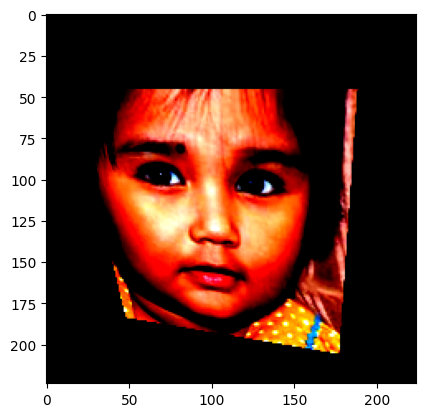

In [10]:
def display_torch_img(dataset, index):
    """Displays a single image from the given dataset at the given index.

    Args:
        dataset: A PyTorch dataset object or the array of tensors.
        index: The index of the image to display.

    Returns:
        None.
    """

    # Check if the dataset is a FairFaceDataset object.
    if type(dataset) == data.FairFaceDataset:

        # Get the image from the dataset.
        img = dataset[index]['image']

        # If the image is a 4D tensor, squeeze it to a 3D tensor.
        if len(dataset[index]['image'].shape) == 4:
            img = torch.squeeze(img)

    # Otherwise, the dataset is assumed to be an array of tensors.
    else:

        # Get the image from the dataset.
        img = dataset[index]

    # Permute the image axes so that the channel axis is the last axis.
    img = img.permute(1, 2, 0)

    # Display the image using Matplotlib.
    plt.imshow(img)
    plt.show()

display_torch_img(fairface_train, 35)

### Sample data

In [11]:
img_grid = torchvision.utils.make_grid(fairface_train[13]['image'])
writer.add_image('fairface_image1', img_grid)

img_grid = torchvision.utils.make_grid(fairface_train[26]['image'])
writer.add_image('fairface_image2', img_grid)

for i in range(5):
    img_grid = torchvision.utils.make_grid(fairface_train[43 + i]['image'])
    writer.add_image(f'fairface_image{i + 3}', img_grid)

### First try of training a neural network

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet = resnet.to(device)
model = resnet_model.FairFaceResNet(resnet).to(device)

# For race and age classes
bce = nn.BCELoss().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10, 15, 20, 25], gamma=0.5, verbose=True)

Adjusting learning rate of group 0 to 1.0000e-04.


### Train model

In [13]:
# map ages
mappings = {'age_map' : utils.get_mappings(age_dict),
            'gender_map' : utils.get_mappings(gender_dict),
            'race_map' : utils.get_mappings(race_dict)}


class_dicts = {'age' : age_dict, 
               'race' : race_dict, 
               'gender': gender_dict}
# train the model
best_model = train.train_model(model, criterion, 
                               optimizer, scheduler_lr=scheduler, 
                               device=device, loaders=[train_loader, test_loader],
                               tensor_writer=writer, mappings=mappings, class_dicts=class_dicts,
                               class_weights=class_weights, n_epochs=35)

100%|██████████| 272/272 [01:59<00:00,  2.28it/s]


Training step:
Epoch = 1, Loss = 5.665336608886719
Age accuracy = 0.18267886735355574	Race accuracy = 0.14256070322069314	Gender accuracy = 0.5202824410980618
Age loss = 2.100086212158203	Race loss = 1.9545117616653442	Gender Loss = 0.6922140121459961


100%|██████████| 68/68 [00:12<00:00,  5.30it/s]


Validation step:
Epoch = 1, Loss = 5.605871326783124
Age accuracy = 0.24439448959594212	Race accuracy = 0.14260187907083982	Gender accuracy = 0.6057409648971123
Age loss = 2.0721206665039062	Race loss = 1.9442858695983887	Gender Loss = 0.6753796935081482
End of Epoch: 1 	Training Loss: 5.665336608886719 	Validation Loss: 5.605871326783124
Validation loss decreased (inf --> 5.605871326783124).  Saving model ...


100%|██████████| 272/272 [01:58<00:00,  2.30it/s]


Training step:
Epoch = 2, Loss = 5.293417453765869
Age accuracy = 0.27189278766481734	Race accuracy = 0.15555875783557893	Gender accuracy = 0.6045968729735571
Age loss = 1.866214394569397	Race loss = 1.9455535411834717	Gender Loss = 0.6599953770637512


100%|██████████| 68/68 [00:12<00:00,  5.24it/s]


Validation step:
Epoch = 2, Loss = 5.264714675791123
Age accuracy = 0.23874574903452647	Race accuracy = 0.2288892731569543	Gender accuracy = 0.7063807712260073
Age loss = 1.902685284614563	Race loss = 1.89837646484375	Gender Loss = 0.5745049118995667
End of Epoch: 2 	Training Loss: 5.293417453765869 	Validation Loss: 5.264714675791123
Validation loss decreased (5.605871326783124 --> 5.264714675791123).  Saving model ...


100%|██████████| 272/272 [02:00<00:00,  2.26it/s]


Training step:
Epoch = 3, Loss = 4.954524993896484
Age accuracy = 0.3223142877728943	Race accuracy = 0.21334390085741048	Gender accuracy = 0.7154261834426111
Age loss = 1.7129862308502197	Race loss = 1.882794976234436	Gender Loss = 0.5520415902137756


100%|██████████| 68/68 [00:12<00:00,  5.33it/s]


Validation step:
Epoch = 3, Loss = 4.734082474428065
Age accuracy = 0.32716583088362444	Race accuracy = 0.31166061444463655	Gender accuracy = 0.8192979422445098
Age loss = 1.7311041355133057	Race loss = 1.720981240272522	Gender Loss = 0.3753863573074341
End of Epoch: 3 	Training Loss: 4.954524993896484 	Validation Loss: 4.734082474428065
Validation loss decreased (5.264714675791123 --> 4.734082474428065).  Saving model ...


100%|██████████| 272/272 [01:58<00:00,  2.30it/s]


Training step:
Epoch = 4, Loss = 4.5987935066223145
Age accuracy = 0.3641184523380647	Race accuracy = 0.2627566827581238	Gender accuracy = 0.7876071763095324
Age loss = 1.5915818214416504	Race loss = 1.765821099281311	Gender Loss = 0.4406423568725586


100%|██████████| 68/68 [00:13<00:00,  5.18it/s]


Validation step:
Epoch = 4, Loss = 4.319908464656157
Age accuracy = 0.3776010144676927	Race accuracy = 0.3269929102541933	Gender accuracy = 0.862585739812093
Age loss = 1.5386439561843872	Race loss = 1.6346800327301025	Gender Loss = 0.30110999941825867
End of Epoch: 4 	Training Loss: 4.5987935066223145 	Validation Loss: 4.319908464656157
Validation loss decreased (4.734082474428065 --> 4.319908464656157).  Saving model ...


100%|██████████| 272/272 [01:58<00:00,  2.29it/s]


Training step:
Epoch = 5, Loss = 4.344922065734863
Age accuracy = 0.40304056488219614	Race accuracy = 0.28770084300021614	Gender accuracy = 0.8231716982491534
Age loss = 1.4862544536590576	Race loss = 1.7007784843444824	Gender Loss = 0.3806934356689453


100%|██████████| 68/68 [00:13<00:00,  5.16it/s]


Validation step:
Epoch = 5, Loss = 4.041037822470946
Age accuracy = 0.4486713931638711	Race accuracy = 0.3454954176033201	Gender accuracy = 0.8776874747824082
Age loss = 1.4058592319488525	Race loss = 1.5717192888259888	Gender Loss = 0.28284138441085815
End of Epoch: 5 	Training Loss: 4.344922065734863 	Validation Loss: 4.041037822470946
Validation loss decreased (4.319908464656157 --> 4.041037822470946).  Saving model ...


100%|██████████| 272/272 [01:58<00:00,  2.29it/s]


Training step:
Epoch = 6, Loss = 4.165299892425537
Age accuracy = 0.4316161106707976	Race accuracy = 0.30300453923193316	Gender accuracy = 0.8414871388428561
Age loss = 1.4067388772964478	Race loss = 1.658821702003479	Gender Loss = 0.3465842604637146


100%|██████████| 68/68 [00:13<00:00,  5.19it/s]


Validation step:
Epoch = 6, Loss = 3.952367481063394
Age accuracy = 0.45921955155916766	Race accuracy = 0.3646896074701712	Gender accuracy = 0.889215516744481
Age loss = 1.3699113130569458	Race loss = 1.5485550165176392	Gender Loss = 0.25967055559158325
End of Epoch: 6 	Training Loss: 4.165299892425537 	Validation Loss: 3.952367481063394
Validation loss decreased (4.041037822470946 --> 3.952367481063394).  Saving model ...


100%|██████████| 272/272 [01:58<00:00,  2.30it/s]


Training step:
Epoch = 7, Loss = 4.015231609344482
Age accuracy = 0.45137257727501984	Race accuracy = 0.32110382592405795	Gender accuracy = 0.8530297571871173
Age loss = 1.341285228729248	Race loss = 1.619937777519226	Gender Loss = 0.3271995484828949


100%|██████████| 68/68 [00:13<00:00,  5.17it/s]


Validation step:
Epoch = 7, Loss = 3.754247146494248
Age accuracy = 0.488270217303591	Race accuracy = 0.38953253789843795	Gender accuracy = 0.8895613580033431
Age loss = 1.2709650993347168	Race loss = 1.5081746578216553	Gender Loss = 0.2522282004356384
End of Epoch: 7 	Training Loss: 4.015231609344482 	Validation Loss: 3.754247146494248
Validation loss decreased (3.952367481063394 --> 3.754247146494248).  Saving model ...


100%|██████████| 272/272 [01:58<00:00,  2.30it/s]


Training step:
Epoch = 8, Loss = 3.8814258575439453
Age accuracy = 0.4726853519706031	Race accuracy = 0.34191224151595934	Gender accuracy = 0.8636212983644355
Age loss = 1.2882622480392456	Race loss = 1.578964114189148	Gender Loss = 0.30801743268966675


100%|██████████| 68/68 [00:13<00:00,  5.20it/s]


Validation step:
Epoch = 8, Loss = 3.6565851393867943
Age accuracy = 0.502853190385613	Race accuracy = 0.41362614559917	Gender accuracy = 0.8991872730416739
Age loss = 1.2268867492675781	Race loss = 1.4839422702789307	Gender Loss = 0.2425534576177597
End of Epoch: 8 	Training Loss: 3.8814258575439453 	Validation Loss: 3.6565851393867943
Validation loss decreased (3.754247146494248 --> 3.6565851393867943).  Saving model ...


100%|██████████| 272/272 [01:58<00:00,  2.30it/s]


Training step:
Epoch = 9, Loss = 3.796189785003662
Age accuracy = 0.48353627782981484	Race accuracy = 0.35718711722746593	Gender accuracy = 0.8686792996613589
Age loss = 1.2539039850234985	Race loss = 1.5529654026031494	Gender Loss = 0.29807406663894653


100%|██████████| 68/68 [00:13<00:00,  5.20it/s]


Validation step:
Epoch = 9, Loss = 3.6359619848868427
Age accuracy = 0.5010087036716814	Race accuracy = 0.4321862931581071	Gender accuracy = 0.8913482045074644
Age loss = 1.2202415466308594	Race loss = 1.4739677906036377	Gender Loss = 0.24562866985797882
End of Epoch: 9 	Training Loss: 3.796189785003662 	Validation Loss: 3.6359619848868427
Validation loss decreased (3.6565851393867943 --> 3.6359619848868427).  Saving model ...


100%|██████████| 272/272 [01:58<00:00,  2.30it/s]


Training step:
Epoch = 10, Loss = 3.6918671131134033
Age accuracy = 0.49507889617407597	Race accuracy = 0.38275091865408173	Gender accuracy = 0.8730888392535485
Age loss = 1.2192904949188232	Race loss = 1.5110719203948975	Gender Loss = 0.2878096103668213


100%|██████████| 68/68 [00:13<00:00,  5.17it/s]


Validation step:
Epoch = 10, Loss = 3.5529890446101917
Age accuracy = 0.49466828059254137	Race accuracy = 0.4628508847772206	Gender accuracy = 0.9002247968182604
Age loss = 1.214487075805664	Race loss = 1.4142969846725464	Gender Loss = 0.231911301612854
End of Epoch: 10 	Training Loss: 3.6918671131134033 	Validation Loss: 3.5529890446101917
Validation loss decreased (3.6359619848868427 --> 3.5529890446101917).  Saving model ...


100%|██████████| 272/272 [01:58<00:00,  2.30it/s]


Training step:
Epoch = 11, Loss = 3.5720224380493164
Age accuracy = 0.5027451545500397	Race accuracy = 0.4200446718063261	Gender accuracy = 0.8764752503782693
Age loss = 1.2006559371948242	Race loss = 1.434112310409546	Gender Loss = 0.28220334649086


100%|██████████| 68/68 [00:13<00:00,  5.14it/s]


Validation step:
Epoch = 11, Loss = 3.393067310838138
Age accuracy = 0.5042365554210617	Race accuracy = 0.5030261110150441	Gender accuracy = 0.8947489768862759
Age loss = 1.1881023645401	Race loss = 1.3057199716567993	Gender Loss = 0.2521860897541046
End of Epoch: 11 	Training Loss: 3.5720224380493164 	Validation Loss: 3.393067310838138
Validation loss decreased (3.5529890446101917 --> 3.393067310838138).  Saving model ...


100%|██████████| 272/272 [01:58<00:00,  2.30it/s]


Training step:
Epoch = 12, Loss = 3.426037073135376
Age accuracy = 0.513567259889041	Race accuracy = 0.4533756034296419	Gender accuracy = 0.8825996109229771
Age loss = 1.170506238937378	Race loss = 1.3515311479568481	Gender Loss = 0.26965779066085815


100%|██████████| 68/68 [00:13<00:00,  5.19it/s]


Validation step:
Epoch = 12, Loss = 3.309033025713528
Age accuracy = 0.5222203008818952	Race accuracy = 0.507752608219494	Gender accuracy = 0.9032797279382097
Age loss = 1.160545825958252	Race loss = 1.276430368423462	Gender Loss = 0.22663871943950653
End of Epoch: 12 	Training Loss: 3.426037073135376 	Validation Loss: 3.309033025713528
Validation loss decreased (3.393067310838138 --> 3.309033025713528).  Saving model ...


100%|██████████| 272/272 [01:59<00:00,  2.28it/s]


Training step:
Epoch = 13, Loss = 3.3158671855926514
Age accuracy = 0.5218243389293177	Race accuracy = 0.4782333021111031	Gender accuracy = 0.8850349448807551
Age loss = 1.141722321510315	Race loss = 1.2958005666732788	Gender Loss = 0.2642376124858856


100%|██████████| 68/68 [00:13<00:00,  5.13it/s]


Validation step:
Epoch = 13, Loss = 3.3272287600180683
Age accuracy = 0.499048936538129	Race accuracy = 0.5319038561300363	Gender accuracy = 0.8995907545103464
Age loss = 1.2049607038497925	Race loss = 1.2310535907745361	Gender Loss = 0.2407727837562561
End of Epoch: 13 	Training Loss: 3.3158671855926514 	Validation Loss: 3.3272287600180683


100%|██████████| 272/272 [01:57<00:00,  2.31it/s]


Training step:
Epoch = 14, Loss = 3.241497039794922
Age accuracy = 0.5307154694142229	Race accuracy = 0.500698897615102	Gender accuracy = 0.8884501765256863
Age loss = 1.1294364929199219	Race loss = 1.2493289709091187	Gender Loss = 0.259477823972702


100%|██████████| 68/68 [00:12<00:00,  5.30it/s]


Validation step:
Epoch = 14, Loss = 3.2069471969324
Age accuracy = 0.5223932215113263	Race accuracy = 0.5414144907487464	Gender accuracy = 0.9082944261917113
Age loss = 1.1520838737487793	Race loss = 1.2008397579193115	Gender Loss = 0.22375436127185822
End of Epoch: 14 	Training Loss: 3.241497039794922 	Validation Loss: 3.2069471969324
Validation loss decreased (3.309033025713528 --> 3.2069471969324).  Saving model ...


100%|██████████| 272/272 [01:58<00:00,  2.30it/s]


Training step:
Epoch = 15, Loss = 3.190361261367798
Age accuracy = 0.5291591613228619	Race accuracy = 0.5145759780964047	Gender accuracy = 0.8934505367821889
Age loss = 1.1255995035171509	Race loss = 1.212310552597046	Gender Loss = 0.253216028213501


100%|██████████| 68/68 [00:13<00:00,  5.16it/s]


Validation step:
Epoch = 15, Loss = 3.269914991715375
Age accuracy = 0.5012392645109228	Race accuracy = 0.5406075278114012	Gender accuracy = 0.9083520664015217
Age loss = 1.1696447134017944	Race loss = 1.2329893112182617	Gender Loss = 0.22076041996479034
End of Epoch: 15 	Training Loss: 3.190361261367798 	Validation Loss: 3.269914991715375


100%|██████████| 272/272 [01:58<00:00,  2.29it/s]


Training step:
Epoch = 16, Loss = 3.093519449234009
Age accuracy = 0.5435550111679516	Race accuracy = 0.5326032134880034	Gender accuracy = 0.8992578716045825
Age loss = 1.091771125793457	Race loss = 1.1752355098724365	Gender Loss = 0.24496008455753326


100%|██████████| 68/68 [00:13<00:00,  5.07it/s]


Validation step:
Epoch = 16, Loss = 3.260387764257543
Age accuracy = 0.4866562914289008	Race accuracy = 0.5456798662747132	Gender accuracy = 0.9105423943743155
Age loss = 1.1970269680023193	Race loss = 1.1906529664993286	Gender Loss = 0.21752609312534332
End of Epoch: 16 	Training Loss: 3.093519449234009 	Validation Loss: 3.260387764257543


100%|██████████| 272/272 [02:01<00:00,  2.24it/s]


Training step:
Epoch = 17, Loss = 3.0466127395629883
Age accuracy = 0.5507457309604439	Race accuracy = 0.5376323942647164	Gender accuracy = 0.9007277181353124
Age loss = 1.0714011192321777	Race loss = 1.1625036001205444	Gender Loss = 0.24055133759975433


100%|██████████| 68/68 [00:13<00:00,  4.87it/s]


Validation step:
Epoch = 17, Loss = 3.179964041008669
Age accuracy = 0.5059657617153727	Race accuracy = 0.5525966914519569	Gender accuracy = 0.9074298230445559
Age loss = 1.1612305641174316	Race loss = 1.1654611825942993	Gender Loss = 0.22584541141986847
End of Epoch: 17 	Training Loss: 3.0466127395629883 	Validation Loss: 3.179964041008669
Validation loss decreased (3.2069471969324 --> 3.179964041008669).  Saving model ...


100%|██████████| 272/272 [02:04<00:00,  2.19it/s]


Training step:
Epoch = 18, Loss = 3.042651414871216
Age accuracy = 0.5500252179551841	Race accuracy = 0.5412349592910152	Gender accuracy = 0.9002377692917357
Age loss = 1.0747910737991333	Race loss = 1.1541074514389038	Gender Loss = 0.2429039031267166


100%|██████████| 68/68 [00:13<00:00,  4.94it/s]


Validation step:
Epoch = 18, Loss = 3.2853836522382847
Age accuracy = 0.48850077814283244	Race accuracy = 0.5532883739696812	Gender accuracy = 0.9070263415758834
Age loss = 1.1991302967071533	Race loss = 1.2079315185546875	Gender Loss = 0.22244825959205627
End of Epoch: 18 	Training Loss: 3.042651414871216 	Validation Loss: 3.2853836522382847


100%|██████████| 272/272 [01:58<00:00,  2.29it/s]


Training step:
Epoch = 19, Loss = 2.9577460289001465
Age accuracy = 0.5579940917933569	Race accuracy = 0.5559046040781036	Gender accuracy = 0.9049931551264501
Age loss = 1.0540454387664795	Race loss = 1.1103650331497192	Gender Loss = 0.235004723072052


100%|██████████| 68/68 [00:13<00:00,  5.08it/s]


Validation step:
Epoch = 19, Loss = 3.09629448371775
Age accuracy = 0.5324802582281399	Race accuracy = 0.5634906911061156	Gender accuracy = 0.9110611562626088
Age loss = 1.1185345649719238	Race loss = 1.1512478590011597	Gender Loss = 0.2167665809392929
End of Epoch: 19 	Training Loss: 2.9577460289001465 	Validation Loss: 3.09629448371775
Validation loss decreased (3.179964041008669 --> 3.09629448371775).  Saving model ...


100%|██████████| 272/272 [01:59<00:00,  2.27it/s]


Training step:
Epoch = 20, Loss = 2.904902219772339
Age accuracy = 0.5612940413574465	Race accuracy = 0.5686288637509908	Gender accuracy = 0.9057713091721306
Age loss = 1.0394723415374756	Race loss = 1.0844252109527588	Gender Loss = 0.23307718336582184


100%|██████████| 68/68 [00:13<00:00,  5.08it/s]


Validation step:
Epoch = 20, Loss = 3.120061986586627
Age accuracy = 0.5213556977347398	Race accuracy = 0.558648913482045	Gender accuracy = 0.9099659922762119
Age loss = 1.1327097415924072	Race loss = 1.1531870365142822	Gender Loss = 0.2174803465604782
End of Epoch: 20 	Training Loss: 2.904902219772339 	Validation Loss: 3.120061986586627


100%|██████████| 272/272 [01:59<00:00,  2.28it/s]


Training step:
Epoch = 21, Loss = 2.9033727645874023
Age accuracy = 0.567764248144679	Race accuracy = 0.566582606816053	Gender accuracy = 0.9091433100367462
Age loss = 1.0384111404418945	Race loss = 1.0871773958206177	Gender Loss = 0.22351500391960144


100%|██████████| 68/68 [00:13<00:00,  5.07it/s]


Validation step:
Epoch = 21, Loss = 3.1502097564585068
Age accuracy = 0.5158222375929449	Race accuracy = 0.56735258516341	Gender accuracy = 0.907775664303418
Age loss = 1.1280993223190308	Race loss = 1.181823968887329	Gender Loss = 0.22826305031776428
End of Epoch: 21 	Training Loss: 2.9033727645874023 	Validation Loss: 3.1502097564585068


100%|██████████| 272/272 [01:59<00:00,  2.27it/s]


Training step:
Epoch = 22, Loss = 2.844259023666382
Age accuracy = 0.5676345558037322	Race accuracy = 0.58077671301967	Gender accuracy = 0.9115498234743137
Age loss = 1.0238639116287231	Race loss = 1.0564401149749756	Gender Loss = 0.2194756120443344


100%|██████████| 68/68 [00:13<00:00,  5.14it/s]


Validation step:
Epoch = 22, Loss = 3.2207079775193157
Age accuracy = 0.5191653697619459	Race accuracy = 0.5533460141794916	Gender accuracy = 0.9087555478701943
Age loss = 1.1491734981536865	Race loss = 1.2127807140350342	Gender Loss = 0.23634593188762665
End of Epoch: 22 	Training Loss: 2.844259023666382 	Validation Loss: 3.2207079775193157


100%|██████████| 272/272 [01:59<00:00,  2.28it/s]


Training step:
Epoch = 23, Loss = 2.805265188217163
Age accuracy = 0.5756178399020102	Race accuracy = 0.5824194826716622	Gender accuracy = 0.9138122343108294
Age loss = 1.0076014995574951	Race loss = 1.0457663536071777	Gender Loss = 0.21307682991027832


100%|██████████| 68/68 [00:13<00:00,  5.05it/s]


Validation step:
Epoch = 23, Loss = 3.1247046449605156
Age accuracy = 0.5014121851403539	Race accuracy = 0.5757104155859127	Gender accuracy = 0.9108305954233673
Age loss = 1.1494081020355225	Race loss = 1.1355966329574585	Gender Loss = 0.21801377832889557
End of Epoch: 23 	Training Loss: 2.805265188217163 	Validation Loss: 3.1247046449605156


100%|██████████| 272/272 [02:00<00:00,  2.26it/s]


Training step:
Epoch = 24, Loss = 2.7823379039764404
Age accuracy = 0.5771453274731609	Race accuracy = 0.589941638446574	Gender accuracy = 0.9170689530946033
Age loss = 1.001802921295166	Race loss = 1.035521388053894	Gender Loss = 0.20627950131893158


100%|██████████| 68/68 [00:13<00:00,  5.09it/s]


Validation step:
Epoch = 24, Loss = 3.254746163592619
Age accuracy = 0.5008934232520607	Race accuracy = 0.5642976540434608	Gender accuracy = 0.9118681191999539
Age loss = 1.2020381689071655	Race loss = 1.1785070896148682	Gender Loss = 0.2207144796848297
End of Epoch: 24 	Training Loss: 2.7823379039764404 	Validation Loss: 3.254746163592619


100%|██████████| 272/272 [01:59<00:00,  2.27it/s]


Training step:
Epoch = 25, Loss = 2.737941026687622
Age accuracy = 0.5819871748685064	Race accuracy = 0.5961236400317026	Gender accuracy = 0.9170113120541826
Age loss = 0.9908017516136169	Race loss = 1.0110602378845215	Gender Loss = 0.20847977697849274


100%|██████████| 68/68 [00:13<00:00,  5.13it/s]


Validation step:
Epoch = 25, Loss = 3.1387354205636417
Age accuracy = 0.5143812323476857	Race accuracy = 0.5759986166349645	Gender accuracy = 0.9135396852844544
Age loss = 1.1260977983474731	Race loss = 1.1760646104812622	Gender Loss = 0.2230100929737091
End of Epoch: 25 	Training Loss: 2.737941026687622 	Validation Loss: 3.1387354205636417


100%|██████████| 272/272 [01:58<00:00,  2.30it/s]


Training step:
Epoch = 26, Loss = 2.7060117721557617
Age accuracy = 0.5860796887383817	Race accuracy = 0.6057064630016572	Gender accuracy = 0.916968081273867
Age loss = 0.9850267767906189	Race loss = 0.991905689239502	Gender Loss = 0.20588624477386475


100%|██████████| 68/68 [00:13<00:00,  5.10it/s]


Validation step:
Epoch = 26, Loss = 3.0817688247736763
Age accuracy = 0.5219320998328434	Race accuracy = 0.5784195054469998	Gender accuracy = 0.9151536111591446
Age loss = 1.1142442226409912	Race loss = 1.1438847780227661	Gender Loss = 0.21835681796073914
End of Epoch: 26 	Training Loss: 2.7060117721557617 	Validation Loss: 3.0817688247736763
Validation loss decreased (3.09629448371775 --> 3.0817688247736763).  Saving model ...


100%|██████████| 272/272 [01:58<00:00,  2.30it/s]


Training step:
Epoch = 27, Loss = 2.6928441524505615
Age accuracy = 0.590835074573096	Race accuracy = 0.6097413358311118	Gender accuracy = 0.9201383384970099
Age loss = 0.9771080017089844	Race loss = 0.991317868232727	Gender Loss = 0.20406341552734375


100%|██████████| 68/68 [00:13<00:00,  5.09it/s]


Validation step:
Epoch = 27, Loss = 3.2827658653259277
Age accuracy = 0.48878897919188424	Race accuracy = 0.5602051991469249	Gender accuracy = 0.9152688915787653
Age loss = 1.1871951818466187	Race loss = 1.2210235595703125	Gender Loss = 0.2223483920097351
End of Epoch: 27 	Training Loss: 2.6928441524505615 	Validation Loss: 3.2827658653259277


100%|██████████| 272/272 [01:59<00:00,  2.28it/s]


Training step:
Epoch = 28, Loss = 2.7023732662200928
Age accuracy = 0.589869587146048	Race accuracy = 0.5969450248576987	Gender accuracy = 0.9171698249153397
Age loss = 0.9713695645332336	Race loss = 1.0053313970565796	Gender Loss = 0.20933640003204346


100%|██████████| 68/68 [00:13<00:00,  5.15it/s]


Validation step:
Epoch = 28, Loss = 3.210840540773728
Age accuracy = 0.4998558994754741	Race accuracy = 0.5729436855150153	Gender accuracy = 0.9160758545161104
Age loss = 1.1745805740356445	Race loss = 1.1764987707138062	Gender Loss = 0.21959520876407623
End of Epoch: 28 	Training Loss: 2.7023732662200928 	Validation Loss: 3.210840540773728


100%|██████████| 272/272 [01:58<00:00,  2.29it/s]


Training step:
Epoch = 29, Loss = 2.655215263366699
Age accuracy = 0.5901866128683623	Race accuracy = 0.6151019525902442	Gender accuracy = 0.9194466460119605
Age loss = 0.9685518741607666	Race loss = 0.9708058834075928	Gender Loss = 0.201651468873024


100%|██████████| 68/68 [00:13<00:00,  5.17it/s]


Validation step:
Epoch = 29, Loss = 3.1452666766503277
Age accuracy = 0.5289642054297078	Race accuracy = 0.5713873998501354	Gender accuracy = 0.9156723730474379
Age loss = 1.117645263671875	Race loss = 1.1916743516921997	Gender Loss = 0.22587844729423523
End of Epoch: 29 	Training Loss: 2.655215263366699 	Validation Loss: 3.1452666766503277


100%|██████████| 272/272 [01:59<00:00,  2.28it/s]


Training step:
Epoch = 30, Loss = 2.6072580814361572
Age accuracy = 0.6009510771669428	Race accuracy = 0.6198717486850638	Gender accuracy = 0.9221701851718423
Age loss = 0.9494227170944214	Race loss = 0.9565168023109436	Gender Loss = 0.19393636286258698


100%|██████████| 68/68 [00:13<00:00,  5.11it/s]


Validation step:
Epoch = 30, Loss = 3.2111832779996536
Age accuracy = 0.49167098968240247	Race accuracy = 0.5753645743270506	Gender accuracy = 0.9167098968240245
Age loss = 1.1958345174789429	Race loss = 1.1504484415054321	Gender Loss = 0.21638435125350952
End of Epoch: 30 	Training Loss: 2.6072580814361572 	Validation Loss: 3.2111832779996536


100%|██████████| 272/272 [01:59<00:00,  2.27it/s]


Training step:
Epoch = 31, Loss = 2.5952513217926025
Age accuracy = 0.5996397434973701	Race accuracy = 0.6272209813387132	Gender accuracy = 0.9249369551120398
Age loss = 0.9509212374687195	Race loss = 0.9453868865966797	Gender Loss = 0.1902073472738266


100%|██████████| 68/68 [00:13<00:00,  5.22it/s]


Validation step:
Epoch = 31, Loss = 3.1514349334380207
Age accuracy = 0.5084442907372183	Race accuracy = 0.5725402040463428	Gender accuracy = 0.9160182143063
Age loss = 1.152979850769043	Race loss = 1.1536633968353271	Gender Loss = 0.21872487664222717
End of Epoch: 31 	Training Loss: 2.5952513217926025 	Validation Loss: 3.1514349334380207


100%|██████████| 272/272 [01:58<00:00,  2.29it/s]


Training step:
Epoch = 32, Loss = 2.6117355823516846
Age accuracy = 0.6018589235535702	Race accuracy = 0.6237769291735716	Gender accuracy = 0.9239858779450969
Age loss = 0.9485101103782654	Race loss = 0.9622488617897034	Gender Loss = 0.1913316249847412


100%|██████████| 68/68 [00:14<00:00,  4.80it/s]


Validation step:
Epoch = 32, Loss = 3.1276712627971874
Age accuracy = 0.5260245547293793	Race accuracy = 0.5590523949507176	Gender accuracy = 0.9085249870309527
Age loss = 1.1347124576568604	Race loss = 1.153586506843567	Gender Loss = 0.23002108931541443
End of Epoch: 32 	Training Loss: 2.6117355823516846 	Validation Loss: 3.1276712627971874


100%|██████████| 272/272 [01:58<00:00,  2.29it/s]


Training step:
Epoch = 33, Loss = 2.722545862197876
Age accuracy = 0.5747532242956985	Race accuracy = 0.6144246703653001	Gender accuracy = 0.915267670581454
Age loss = 1.006879448890686	Race loss = 0.9769275784492493	Gender Loss = 0.2097621113061905


100%|██████████| 68/68 [00:13<00:00,  5.10it/s]


Validation step:
Epoch = 33, Loss = 3.205469822182375
Age accuracy = 0.506657444233097	Race accuracy = 0.5830883624416393	Gender accuracy = 0.9171710185025074
Age loss = 1.155659556388855	Race loss = 1.1958280801773071	Gender Loss = 0.22079285979270935
End of Epoch: 33 	Training Loss: 2.722545862197876 	Validation Loss: 3.205469822182375


100%|██████████| 272/272 [01:59<00:00,  2.28it/s]


Training step:
Epoch = 34, Loss = 2.5579891204833984
Age accuracy = 0.6049138986958714	Race accuracy = 0.6356509835002522	Gender accuracy = 0.9255854168167735
Age loss = 0.9438439607620239	Race loss = 0.9221636056900024	Gender Loss = 0.1917928159236908


100%|██████████| 68/68 [00:13<00:00,  5.11it/s]


Validation step:
Epoch = 34, Loss = 3.3514717712121853
Age accuracy = 0.4944953599631103	Race accuracy = 0.5919073145426249	Gender accuracy = 0.9076603838837973
Age loss = 1.2168776988983154	Race loss = 1.2345738410949707	Gender Loss = 0.24758777022361755
End of Epoch: 34 	Training Loss: 2.5579891204833984 	Validation Loss: 3.3514717712121853


In [14]:
best_dir = Path('../models/best_model/best_model.pt')
model, optimizer, epoch = utils.load_ckp(best_dir, model, optimizer)
model = model.to(device)


100%|██████████| 43/43 [00:08<00:00,  5.10it/s]


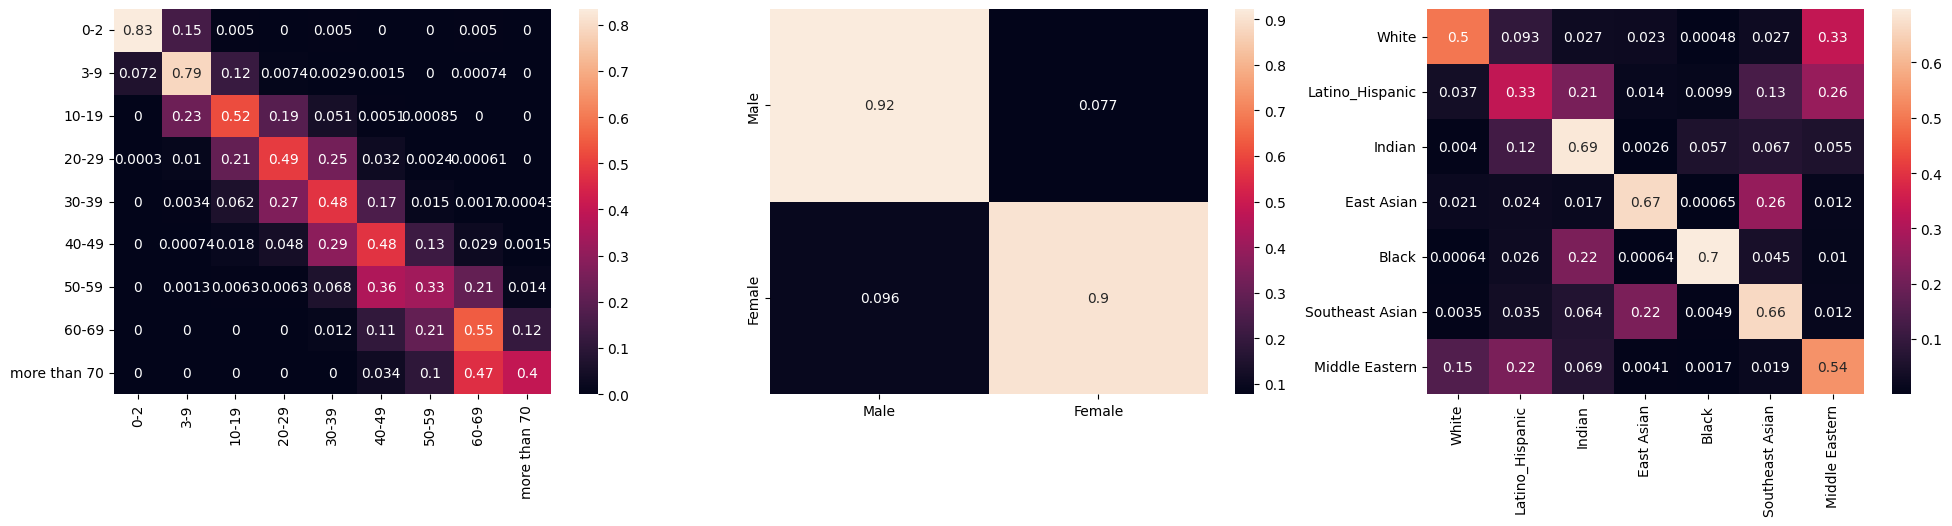

In [15]:
mappings = {'age_map' : utils.get_mappings(age_dict),
            'gender_map' : utils.get_mappings(gender_dict),
            'race_map' : utils.get_mappings(race_dict)}

ages, genders, races = metrics.build_confusion_matrix(model, val_loader, mappings, device=device)

In [16]:
metrics.calc_measures(model, val_loader, device)

100%|██████████| 43/43 [00:08<00:00,  5.04it/s]


,accuracy,precision,recall,f1
age,0.523462,0.513224,0.541957,0.520296
gender,0.914187,0.914090,0.913659,0.913859
race,0.577597,0.601947,0.583426,0.579286


In [19]:
def get_mismatched_classes(model, loader, true_cat, pred_cat, dictionary, output_class, device):
    """Gets the mismatched images for the given model, loader, true category, predicted category, dictionary, output class, and device.

    Args:
        model: The model to evaluate.
        loader: The loader to use to load the data.
        true_cat: The true category.
        pred_cat: The predicted category.
        dictionary: A dictionary mapping category names to indices.
        output_class: The output class.
        device: The device to use.

    Returns:
        A list of mismatched images.
    """
    # Initialize a list to store the mismatched images.
    mismatched_img = []
    # Set the model to evaluation mode.
    model.eval()
    # Iterate over the loader.
    with torch.no_grad():   
          
        for batch in tqdm(loader):
            # Move the images and labels to the device.
            image = batch['image'].to(device)
            age = batch[output_class].to(device)
            # Make a prediction.
            output = model(image)

            # Get the predicted class.
            _, predicted = torch.max(torch.softmax(output[f'{output_class}_pred'].data, dim=1), 1)
            # Iterate over the true and predicted classes.
            for true, pred, img in zip(age, predicted, image):
                # If the true and predicted categories are not the same, add the image to the list of mismatched images.
                if dictionary[true_cat] == int(true) and dictionary[pred_cat] == int(pred):
                    mismatched_img.append(img)
                    
    # Return the list of mismatched images.
    return mismatched_img

true_cat = '50-59'
pred_cat = '40-49'
mism_imgs = get_mismatched_classes(model, val_loader, true_cat, pred_cat, age_dict, 'age', device)
mism_imgs = [i.cpu() for i in mism_imgs]

100%|██████████| 43/43 [00:08<00:00,  5.12it/s]


In [20]:
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F


plt.rcParams["savefig.bbox"] = 'tight'

class Unnormalize(nn.Module):
    def __init__(self, mean, std):
        super(Unnormalize, self).__init__()
        self.mean = torch.tensor(mean)
        self.std = torch.tensor(std)

    def forward(self, x):
        return self.unnormalize(x)

    def unnormalize(self, x):
        # Assuming x is a PyTorch tensor
        return x * self.std[None, :, None, None] + self.mean[None, :, None, None]

def show(imgs, true_cat, pred_cat):
    if not os.path.exists('../mismatched'):
        os.mkdir('../mismatched')
        
    img_batch = []
    cur_batch = 1
    if not isinstance(imgs, list):
        imgs = [imgs]
    for i, img in enumerate(tqdm(imgs)):
        img = np.array(img).transpose(1, 2, 0)
        img_batch.append(img)
        
        if (i + 1) % 20 == 0:
            fig = plt.figure(figsize=(8, 8))
            plt.title(f'True category = {true_cat}; Mismatched one = {pred_cat}')
            columns = 4
            rows = 5
            for i in range(1, columns*rows + 1):
                img = img_batch[i - 1]
                ax = fig.add_subplot(rows, columns, i)
                ax.set_axis_off()
                plt.imshow(img)
            fig.set_tight_layout(tight=True)
            fig.savefig(f'../mismatched/mismatched_age_number_{cur_batch}.png')
            plt.close()

            cur_batch += 1
            img_batch = []

# Example Usage:
mean = [0.485, 0.456, 0.406]  # Replace with your actual mean values
std = [0.229, 0.224, 0.225]   # Replace with your actual standard deviation values

# Create an instance of Unnormalize
unnormalize = Unnormalize(mean=mean, std=std)
show([unnormalize(i).squeeze(0) for i in mism_imgs], true_cat, pred_cat)

100%|██████████| 286/286 [00:12<00:00, 22.85it/s]
